In [3]:
import numpy as np
import scipy

# Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Packages for saving files with timestamps
from datetime import datetime
import os

# Own functions
from independence_models import *
from MLE_estimator_tellurium import *
from MLE_estimator_IPS import * 

In [4]:
# Create a time-stamped folder for the experiment
os.chdir('/home/user')
current_time = datetime.now()
timestamp_str = current_time.strftime('%Y%m%d_%H%M%S')
os.makedirs(timestamp_str, exist_ok=True)
os.chdir(timestamp_str)
print(os.getcwd())

/home/user/20241112_014938


In [5]:
# Fix the random number generator seed for reproducibility
np.random.seed(1234)

In [6]:
# Error tolerance for IPS
err_tol = 1e-8; 

## Helper functions

In [7]:
# Reorders the columns of the input matrix Lambda to ensure that the first rank many columns are linearly independent
def reorder_to_full_rank_block_first(Lambda):
    Q, R, pivot_columns = scipy.linalg.qr(Lambda, mode='economic', pivoting=True)
    return Lambda[:, pivot_columns]

In [8]:
# Start a new plot
def new_plot():
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})

In [9]:
# Create a plot of the time-scales
def timescale_plot(T, scale='log', **kwargs):
    plt.plot(T, '.-', **kwargs)
    plt.xlabel(r'Index of eigenvalue $\lambda$')
    plt.ylabel('|Re($\lambda$)|${}^{-1}$ (timescale)')
    plt.yscale(scale)

In [0]:
# Create a plot of the time-scales
def eigenvalue_plot(T, scale='log', **kwargs):
    plt.plot(1/T, '.-', **kwargs)
    plt.xlabel(r'Index of eigenvalue $\lambda$')
    plt.ylabel('|Re($\lambda$)|')
    plt.yscale(scale)

In [10]:
# Create a plot of the maximal time-scales
def max_eigenvalue_plot(cardinalities, T, scale='linear', **kwargs):
    plt.plot(cardinalities, 1/T, '.-', **kwargs)
    plt.xlabel(r'$|\Lambda|$')
    plt.ylabel('|Re($\lambda_\mathrm{max}$)|')
    plt.yscale(scale)

## Independence model



In [11]:
a = 10
b = 10

# Design matrix
A = independence_model(a, b)

# Random choice of observed distribution
u = np.random.randint(10, 50, size=(1, A.shape[1]))
u = u/sum(u)

# Estimation of MLE with IPS
MLE = IPS(A, u, err_tol=err_tol)

In [12]:
# Save the information about the model

model_str = f'independence_model_{a}_{b}'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [13]:
# Markov basis (sorted so that the first columns form a full-rank matrix)
Lambda_mb = reorder_to_full_rank_block_first(independence_model_markov_basis(a, b))

In [14]:
# Pick cardinalities for the spanning sets
number_of_cardinalities = 10
cardinalities = np.rint(
    np.linspace(te.rank(Lambda_mb), Lambda_mb.shape[1],
                number_of_cardinalities)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(cardinalities)))

0


1


2


3


4


5


6


7


8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


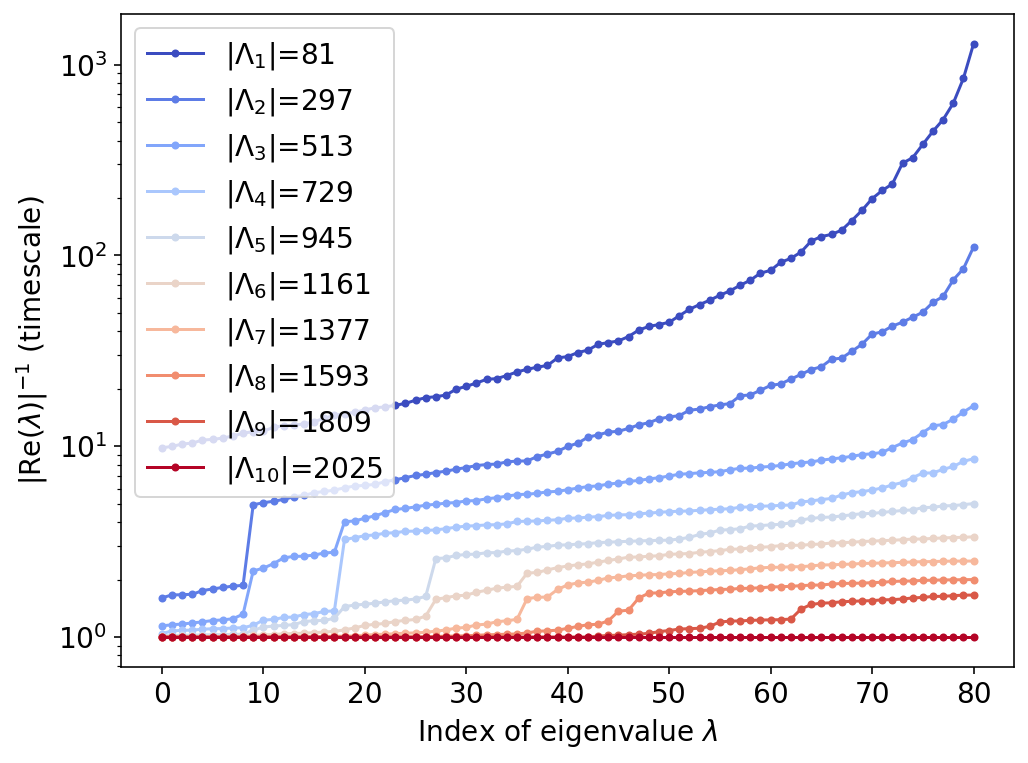

In [15]:
dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

T = np.zeros( (np.size(cardinalities), te.rank(Lambda_mb)) )

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    T[i,:] = timescales(Lambda_mb[:, 0:m], MLE)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T[i,:],
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T[i,:], label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()
plt.savefig(dir_name + f'/independence_model_increasing_lambda.eps',
            format='eps')
plt.savefig(dir_name + f'/independence_model_increasing_lambda.pdf',
            format='pdf')
plt.show()

0


1


2


3


4


5


6


7


8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


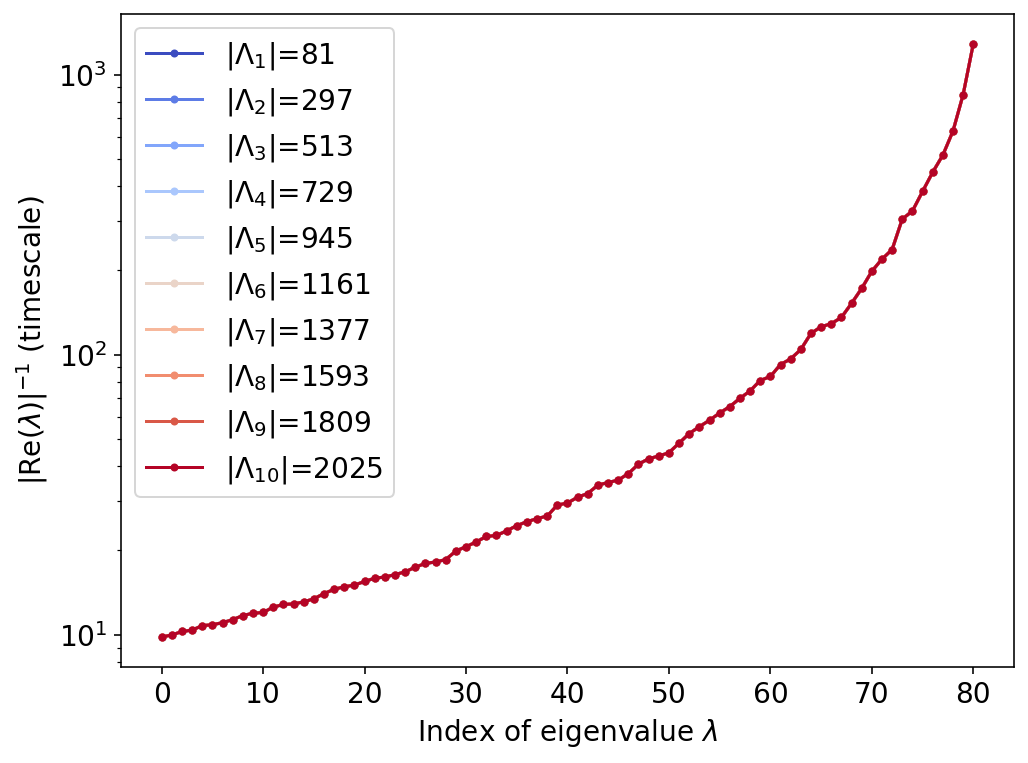

In [17]:
dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Lambda_mb), dtype=int),
     np.random.choice([-1,0,1],
                      size=(te.rank(Lambda_mb),
                            Lambda_mb.shape[1] - te.rank(Lambda_mb)))))
Lambda_spanning_set = np.dot(Lambda_mb[:, 0:te.rank(Lambda_mb)], extension_matrix)

T = np.zeros( (np.size(cardinalities), te.rank(Lambda_mb)) )

new_plot()

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    T[i,:] = timescales(Lambda_spanning_set[:, 0:m], MLE)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T[i,:],
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T[i,:], label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()

plt.savefig(dir_name +
            f"/independence_model_increasing_lambda_to_random_spanning.eps",
            format='eps')
plt.savefig(dir_name +
            f"/independence_model_increasing_lambda_to_random_spanning.pdf",
            format='pdf')

## 4-cycle

In [19]:
A = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
              [0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
              [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
              [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
              [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
              [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
              [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1],
              [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]])


Lambda_mb = np.array([[0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1],
                     [0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 1, 0, 1, 0, -1, 0],
                     [0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0],
                     [0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0],
                     [-1, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0],
                     [0, -1, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
                     [-1, 0, 1, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [1, -1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 1, -1],
                     [1, -1, 0, 0, -1, 1, 0, 0, 0, 0, -1, 1, 0, 0, 1, -1],
                     [1, 0, -1, 0, 0, -1, 0, 1, -1, 0, 1, 0, 0, 1, 0, -1],
                     [0, 1, -1, 0, 0, -1, 1, 0, 0, -1, 1, 0, 0, 1, -1, 0],
                     [1, 0, 0, -1, -1, 0, 0, 1, -1, 0, 0, 1, 1, 0, 0, -1],
                     [0, 1, 0, -1, -1, 0, 1, 0, 0, -1, 0, 1, 1, 0, -1, 0],
                     [0, 0, 1, -1, 0, 0, -1, 1, -1, 1, 0, 0, 1, -1, 0, 0],
                     [0, 0, 0, 0, 1, -1, -1, 1, -1, 1, 1, -1, 0, 0, 0,
                      0]]).transpose()

Lambda_mb = reorder_to_full_rank_block_first(Lambda_mb)

u = np.random.randint(10, 50, size=(1, Lambda_mb.shape[0]))
u = u/sum(u)

MLE = IPS(A, u, err_tol=err_tol)

In [20]:
model_str = f'4_cycle'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [21]:
number_of_cardinalities = 10
cardinalities = np.rint(
    np.linspace(te.rank(Lambda_mb), Lambda_mb.shape[1],
                number_of_cardinalities)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(cardinalities)))

0
1


2
3


4
5


6
7


8
9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


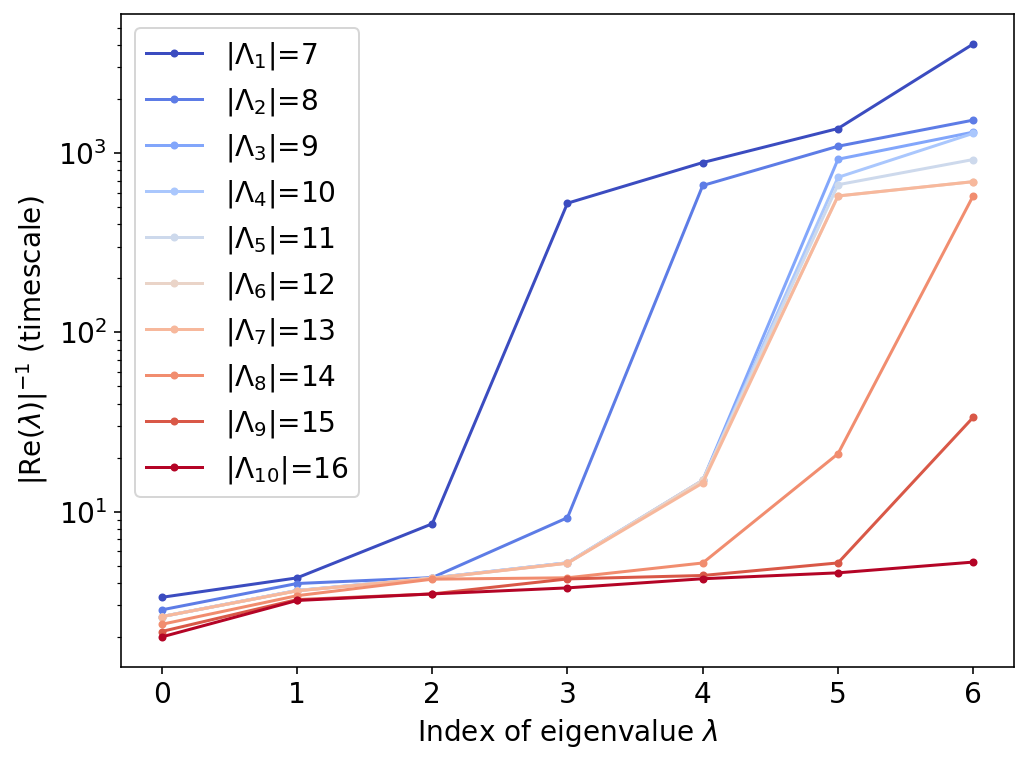

In [22]:
dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

T = np.zeros( (np.size(cardinalities), te.rank(Lambda_mb)) )

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    T[i,:] = timescales(Lambda_mb[:, 0:m], MLE)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T[i,:],
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T[i,:], label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()
plt.savefig(dir_name + "/4-cycle_model_increasing_lambda.eps", format='eps')
plt.savefig(dir_name + "/4-cycle_model_increasing_lambda.pdf", format='pdf')

plt.show()

0
1


2
3


4
5


6
7


8
9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


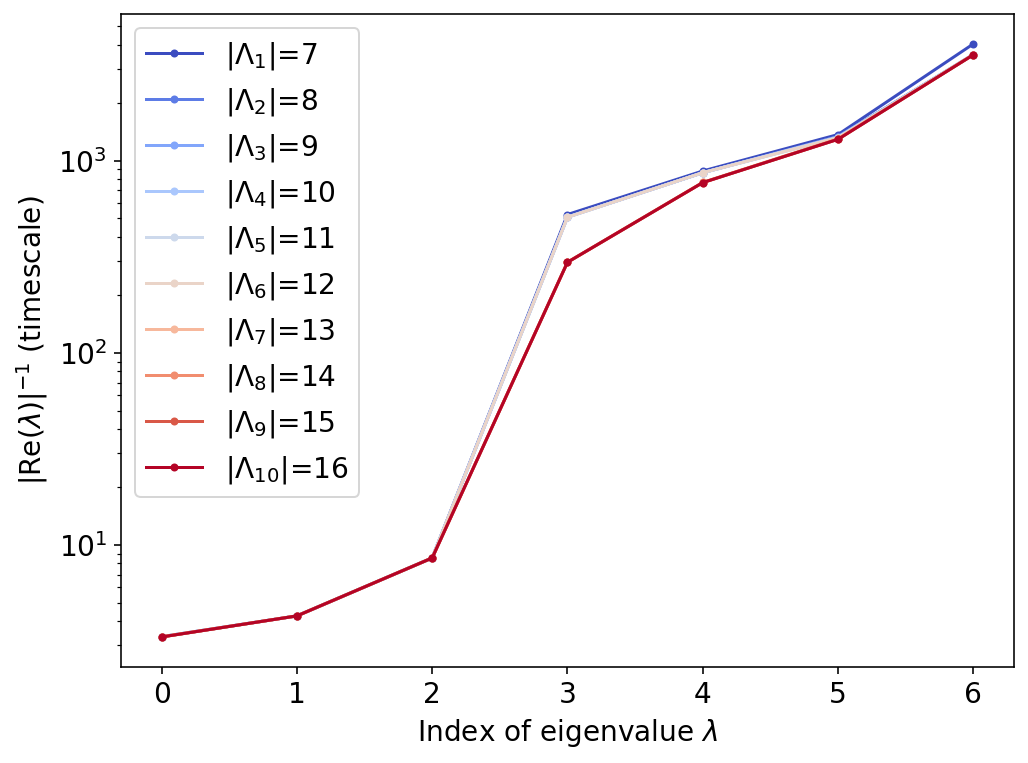

In [24]:
dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Lambda_mb), dtype=int),
     np.random.choice([-1, 0, 1],
                      size=(te.rank(Lambda_mb),
                            Lambda_mb.shape[1] - te.rank(Lambda_mb)))))
Lambda_spanning_set = np.dot(Lambda_mb[:, 0:te.rank(Lambda_mb)], extension_matrix)

new_plot()

T = np.zeros( (np.size(cardinalities), te.rank(Lambda_mb)) )


for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    T[i,:] = timescales(Lambda_spanning_set[:, 0:m], MLE)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T[i,:],
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T[i,:], label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()

plt.savefig(dir_name + "/4-cycle_increaasing_lambda_to_random_spanning.eps",
            format='eps')
plt.savefig(dir_name + "/4-cycle_increasing_lambda_to_random_spanning.pdf",
            format='pdf')

plt.show()

## Random design matrix



In [26]:
A = np.array([[3, 1, 2, 1, 2, 1, 3, 1, 1], [0, 3, 0, 2, 3, 0, 0, 3, 2], [2, 3, 1, 0, 2, 0, 1, 3, 3], [2, 0, 4, 4, 0, 6, 3, 0, 1]])

Lambda_mb = np.array([[0, -1, 0, 1, 0, 1, 2, 0, 3, 0, 1, -1, -2], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 0, 1, 0, 1, -1, 0, 0, 0, 1, -1, 1], [0, 0, -1, 0, 1, 1, 1, -2, 1, 0, 0, -2, -2], [0, 0, 0, 1, -2, -1, -1, 2, 0, -2, -1, 1, 1], [0, -1, 1, 0, -1, -1, 0, 2, 0, 0, 0, 2, 1], [0, 0, 0, -2, 1, -1, -1, -1, -3, 1, -1, 1, 1], [-1, 0, 2, -1, 2, 1, 1, 0, 0, 4, 3, 1, 1], [0, 0, -2, 0, -1, -1, -1, -1, -1, -3, -3, -1, -1]])

Lambda_mb = reorder_to_full_rank_block_first(Lambda_mb)

u = np.random.randint(10, 50, size=(1, Lambda_mb.shape[0]))
u = u/sum(u)

MLE = IPS(A, u, err_tol=err_tol)

In [27]:
model_str = f'random'

os.chdir('/home/user/' + timestamp_str)
os.makedirs(model_str, exist_ok=True)
os.chdir(model_str)

np.savetxt('A.txt', A, delimiter=',', fmt='%d')
np.savetxt('u.txt', u, delimiter=',', fmt='%.5f')

In [28]:
number_of_cardinalities = 10
cardinalities = np.rint(
    np.linspace(te.rank(Lambda_mb), Lambda_mb.shape[1],
                number_of_cardinalities)).astype(int)
colors = cm.coolwarm(np.linspace(0, 1, len(cardinalities)))

0
1
2


3
4
5


6
7
8


9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


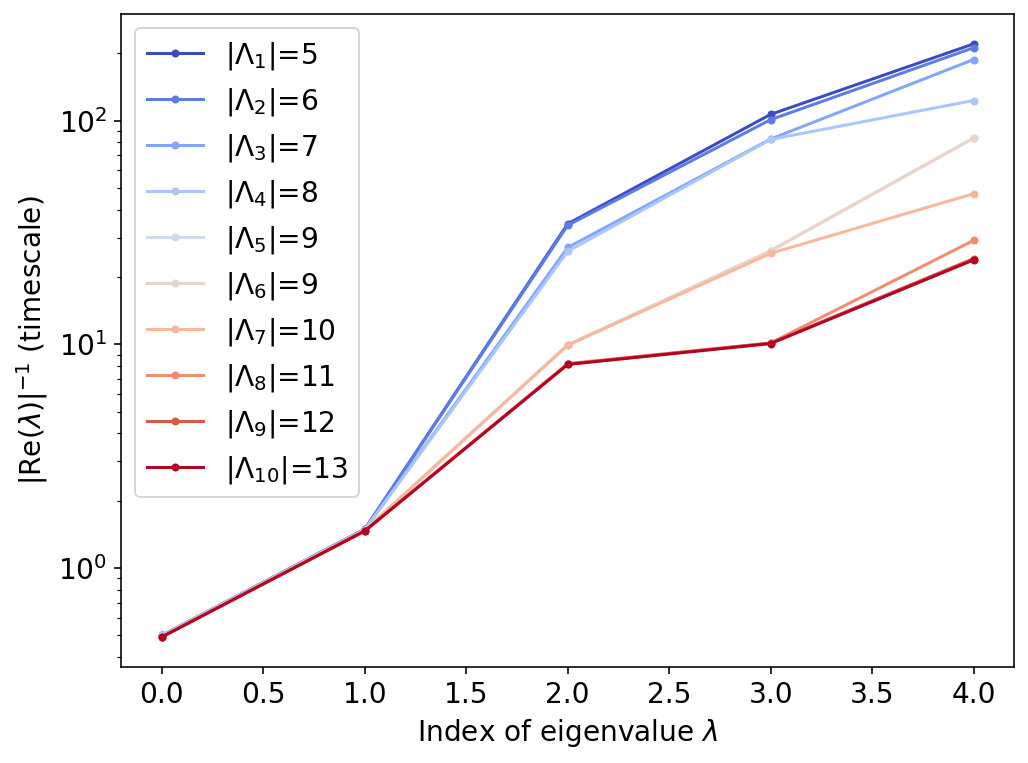

In [29]:
dir_name = f'towards_markov_basis'
os.makedirs(dir_name, exist_ok=True)

new_plot()

T = np.zeros( (np.size(cardinalities), te.rank(Lambda_mb)) )

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_mb[:, 0:m],
               delimiter=',',
               fmt='%d')
    T[i,:] = timescales(Lambda_mb[:, 0:m], MLE)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T[i,:],
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T[i,:], label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()
plt.savefig(dir_name + "/random2_model_increasing_lambda.eps", format='eps')
plt.savefig(dir_name + "/random2_model_increasing_lambda.pdf", format='pdf')
plt.show()

In [31]:
dir_name = f'towards_random_spanning_set'
os.makedirs(dir_name, exist_ok=True)

extension_matrix = np.hstack(
    (np.eye(te.rank(Lambda_mb), dtype=int),
     np.random.choice([-1, 0, 1],
                      size=(te.rank(Lambda_mb),
                            Lambda_mb.shape[1] - te.rank(Lambda_mb)))))
Lambda_spanning_set = np.dot(Lambda_mb[:, 0:te.rank(Lambda_mb)], extension_matrix)

0
1


2
3
4


5
6
7


8
9


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


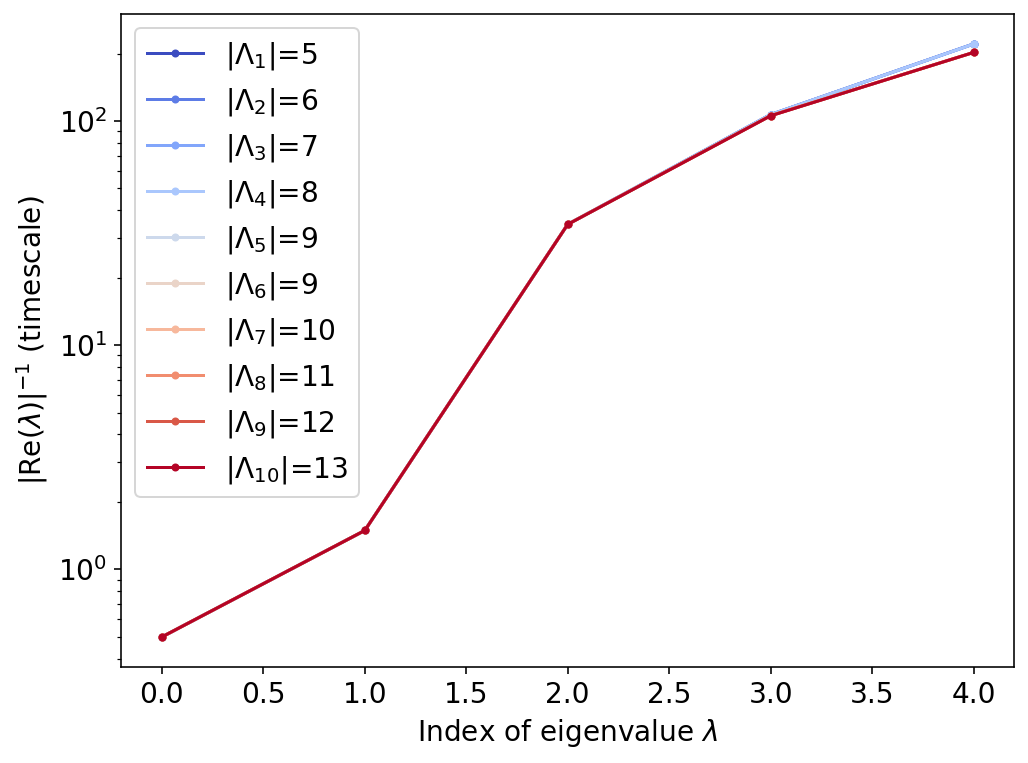

In [32]:
new_plot()

T = np.zeros( (np.size(cardinalities), te.rank(Lambda_mb)) )

for i, m in enumerate(cardinalities):
    print(i)
    np.savetxt(dir_name + f'/Lambda{i+1}.txt',
               Lambda_spanning_set[:, 0:m],
               delimiter=',',
               fmt='%d')
    T[i,:] = timescales(Lambda_spanning_set[:, 0:m], MLE)
    np.savetxt(dir_name + f'/timescales_for_Lambda{i+1}.txt',
               T[i,:],
               delimiter=',',
               fmt='%.5f')
    timescale_plot(T[i,:], label=f'|Λ$_{{{i+1}}}$|={m}', color=colors[i])

plt.legend()

plt.savefig(dir_name + "/random2_increaasing_lambda_to_random_spanning.eps",
            format='eps')
plt.savefig(dir_name + "/random2_increasing_lambda_to_random_spanning.pdf",
            format='pdf')

plt.show()